### Initiale Untersuchungen zu den abgewiesenen Fällen für beide Logs

In [148]:
import pm4py
from src.loader import load_data

log_domestic = load_data('domestic')
log_international = load_data('international')

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

In [149]:
endactivities_log_domestic = pm4py.get_end_activities(log_domestic)
print(f'Es gibt im Domestic-Datensatz {len(endactivities_log_domestic)} unterschiedliche Endaktivitäten.')
endactivities_log_domestic

unique_case_ids_domestic = log_domestic['case:id'].unique()
print(f'Es existieren insgesamt {len(unique_case_ids_domestic)} Traces im zugehörigen log_domestic.')

Es gibt im Domestic-Datensatz 6 unterschiedliche Endaktivitäten.
Es existieren insgesamt 10500 Traces im zugehörigen log_domestic.


In [150]:
from pm4py.statistics.end_activities.log import get as end_activities_get

# Get end activities and their frequencies
end_activities_freq_domestic = end_activities_get.get_end_activities(log_domestic)


print('Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:\n')

# Display the results
for activity, frequency in end_activities_freq_domestic.items():
    print(f"Activity: {activity}, Frequency: {frequency}")

Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:

Activity: Payment Handled, Frequency: 10043
Activity: Declaration SAVED by EMPLOYEE, Frequency: 134
Activity: Declaration REJECTED by MISSING, Frequency: 30
Activity: Declaration REJECTED by EMPLOYEE, Frequency: 284
Activity: Declaration REJECTED by ADMINISTRATION, Frequency: 5
Activity: Declaration REJECTED by SUPERVISOR, Frequency: 4


In [151]:
import pm4py
from pm4py.algo.filtering.log.end_activities import end_activities_filter

# Einschränkung der Auswahl an Endereignissen aus dem log_domestic auf 'rejected-Fälle':
target_end_activities_domestic = [
    # Payment Handled
    #'Declaration SAVED by EMPLOYEE',
    'Declaration REJECTED by MISSING',
    'Declaration REJECTED by EMPLOYEE',
    'Declaration REJECTED by ADMINISTRATION',
    'Declaration REJECTED by SUPERVISOR'
]

# Filtere das Log basierend auf den Endereignissen
filtered_log_rejected_domestic = end_activities_filter.apply(log_domestic, target_end_activities_domestic)

# Überprüfe die Anzahl der verbleibenden Fälle
print(f'Anzahl der abgewiesenen Fälle bei inländischen Reiseanträgen beträgt: {len(filtered_log_rejected_domestic)} von insgesamt {len(unique_case_ids_domestic)}. '
      f'Das entspricht etwa '
      f'{len(filtered_log_rejected_domestic) / len(unique_case_ids_domestic):.2%}')

# Das gefilterte Log speichern
# pm4py.write_xes(filtered_log_rejected_domestic, 'RejectedDomesticDeclarations.xes')



Anzahl der abgewiesenen Fälle bei inländischen Reiseanträgen beträgt: 323 von insgesamt 10500. Das entspricht etwa 3.08%


In [152]:
endactivities_log_international = pm4py.get_end_activities(log_international)
print(f'Es gibt im Interantional-Datensatz {len(endactivities_log_international)} unterschiedliche Endaktivitäten.')
endactivities_log_international

unique_case_ids_international = log_international['case:id'].unique()
print(f'Es existieren insgesamt {len(unique_case_ids_international)} Traces im log_domestic.')

Es gibt im Interantional-Datensatz 10 unterschiedliche Endaktivitäten.
Es existieren insgesamt 6449 Traces im log_domestic.


In [153]:
from pm4py.statistics.end_activities.log import get as end_activities_get

# Get end activities and their frequencies
end_activities_freq_international = end_activities_get.get_end_activities(log_international)


print('Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:\n')
# Display the results
for activity, frequency in end_activities_freq_international.items():
    print(f"Activity: {activity}, Frequency: {frequency}")

Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:

Activity: Payment Handled, Frequency: 5646
Activity: End trip, Frequency: 593
Activity: Declaration SAVED by EMPLOYEE, Frequency: 54
Activity: Permit REJECTED by MISSING, Frequency: 8
Activity: Declaration REJECTED by MISSING, Frequency: 11
Activity: Declaration REJECTED by EMPLOYEE, Frequency: 130
Activity: Declaration FINAL_APPROVED by SUPERVISOR, Frequency: 1
Activity: Send Reminder, Frequency: 2
Activity: Request Payment, Frequency: 3
Activity: Declaration REJECTED by SUPERVISOR, Frequency: 1


In [154]:
print('Die Endaktivitäten des internationalen Datensätze werden nur auf die abgewiesenen Fälle eingeschränkt.')
target_end_activities_international = [
 # 'Payment Handled',
 # 'End trip',
 # 'Declaration SAVED by EMPLOYEE',
 'Permit REJECTED by MISSING',
 'Declaration REJECTED by MISSING',
 'Declaration REJECTED by EMPLOYEE',
 # 'Declaration FINAL_APPROVED by SUPERVISOR',
 # 'Send Reminder',
 # 'Request Payment',
 'Declaration REJECTED by SUPERVISOR'
]

Die Endaktivitäten des internationalen Datensätze werden nur auf die abgewiesenen Fälle eingeschränkt.


In [155]:
import pm4py
from pm4py.algo.filtering.log.end_activities import end_activities_filter

# Filtere das Log basierend auf den Endereignissen
filtered_log_rejected_domestic = end_activities_filter.apply(log_domestic, target_end_activities_domestic)

# Filtere das Log basierend auf den Endereignissen
filtered_log_rejected_international = end_activities_filter.apply(log_international, target_end_activities_international)

print(f'Anzahl der abgewiesenen Fälle bei internationalen Reiseanträgen beträgt: {len(filtered_log_rejected_international)} von insgesamt {len(unique_case_ids_international)}. '
      f'Das entspricht etwa '
      f'{len(filtered_log_rejected_international) / len(unique_case_ids_international):.2%}')

# Optional: Das gefilterte Log speichern
# pm4py.write_xes(filtered_log_rejected_international, 'RejectedInternationalDeclarations.xes')

Anzahl der abgewiesenen Fälle bei internationalen Reiseanträgen beträgt: 150 von insgesamt 6449. Das entspricht etwa 2.33%


-----------

### Visualisierung der Unterschiede

**Log Domestic**

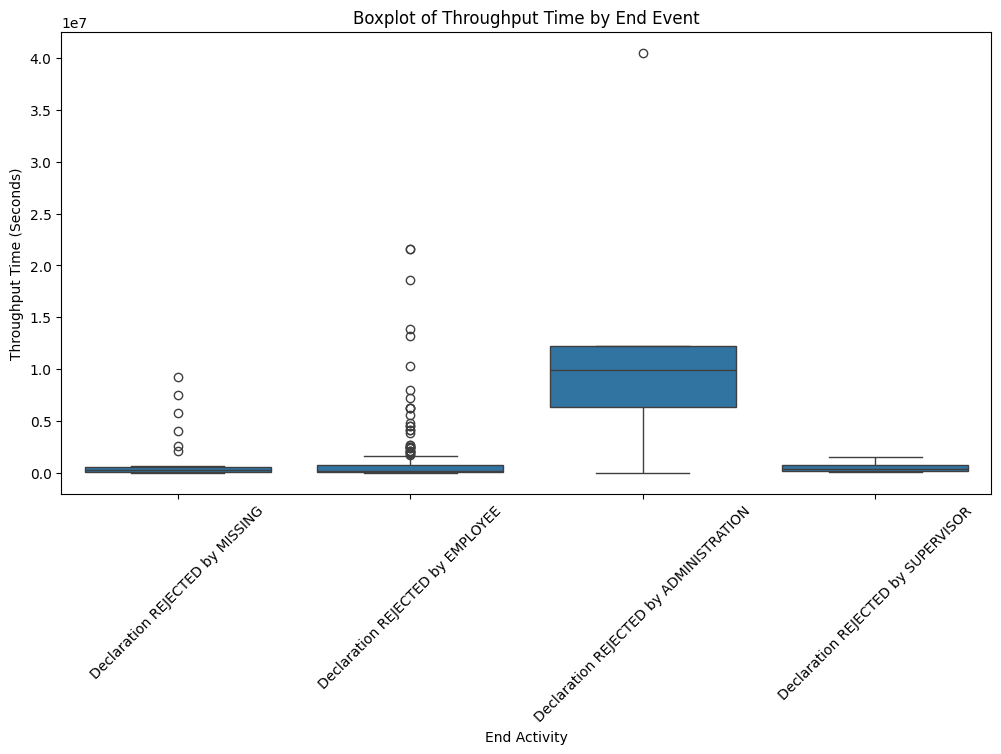

In [156]:
import pm4py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the case durations
filtered_log_rejected_domestic = pm4py.objects.log.util.interval_lifecycle.assign_lead_cycle_time(filtered_log_rejected_domestic, parameters={"timestamp_key": "time:timestamp"})

# Extract the end activities and corresponding case durations
end_activities_domestic = []
case_durations_domestic = []

for trace in filtered_log_rejected_domestic:
    # Get the end activity (last event's activity name)
    end_activity = trace[-1]['concept:name']
    end_activities_domestic.append(end_activity)

    # Calculate the duration as the time difference between the first and last event in the trace
    duration = (trace[-1]['time:timestamp'] - trace[0]['time:timestamp']).total_seconds()
    case_durations_domestic.append(duration)

# Create a DataFrame to map end activities to their respective durations
data_domestic = {'End Activity': end_activities_domestic, 'Duration': case_durations_domestic}
df_domestic = pd.DataFrame(data)

# Plot the boxplot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='End Activity', y='Duration', data=df_domestic)
plt.title('Boxplot of Throughput Time by End Event')
plt.xlabel('End Activity')
plt.ylabel('Throughput Time (Seconds)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


**Log International**

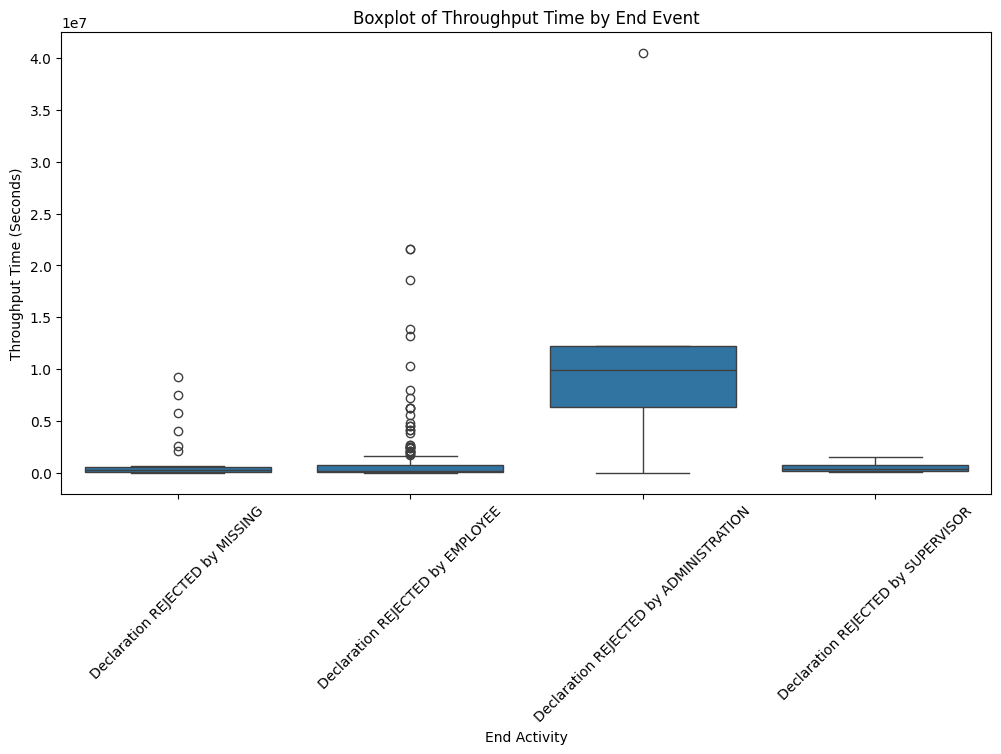

In [157]:
import pm4py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the case durations
filtered_log_rejected_international = pm4py.objects.log.util.interval_lifecycle.assign_lead_cycle_time(filtered_log_rejected_international, parameters={"timestamp_key": "time:timestamp"})

# Extract the end activities and corresponding case durations
end_activities_international = []
case_durations_international = []

for trace in filtered_log_rejected_international:
    # Get the end activity (last event's activity name)
    end_activity = trace[-1]['concept:name']
    end_activities_international.append(end_activity)

    # Calculate the duration as the time difference between the first and last event in the trace
    duration = (trace[-1]['time:timestamp'] - trace[0]['time:timestamp']).total_seconds()
    case_durations_international.append(duration)

# Create a DataFrame to map end activities to their respective durations
data_international = {'End Activity': end_activities_international, 'Duration': case_durations_international}
df_international = pd.DataFrame(data)

# Plot the boxplot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='End Activity', y='Duration', data=df_international)
plt.title('Boxplot of Throughput Time by End Event')
plt.xlabel('End Activity')
plt.ylabel('Throughput Time (Seconds)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


c:\Users\flemm\AppData\Local\pypoetry\Cache\virtualenvs\code-ha-process-mining-2oP8IPjh-py3.11\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 68.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\flemm\AppData\Local\pypoetry\Cache\virtualenvs\code-ha-process-mining-2oP8IPjh-py3.11\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


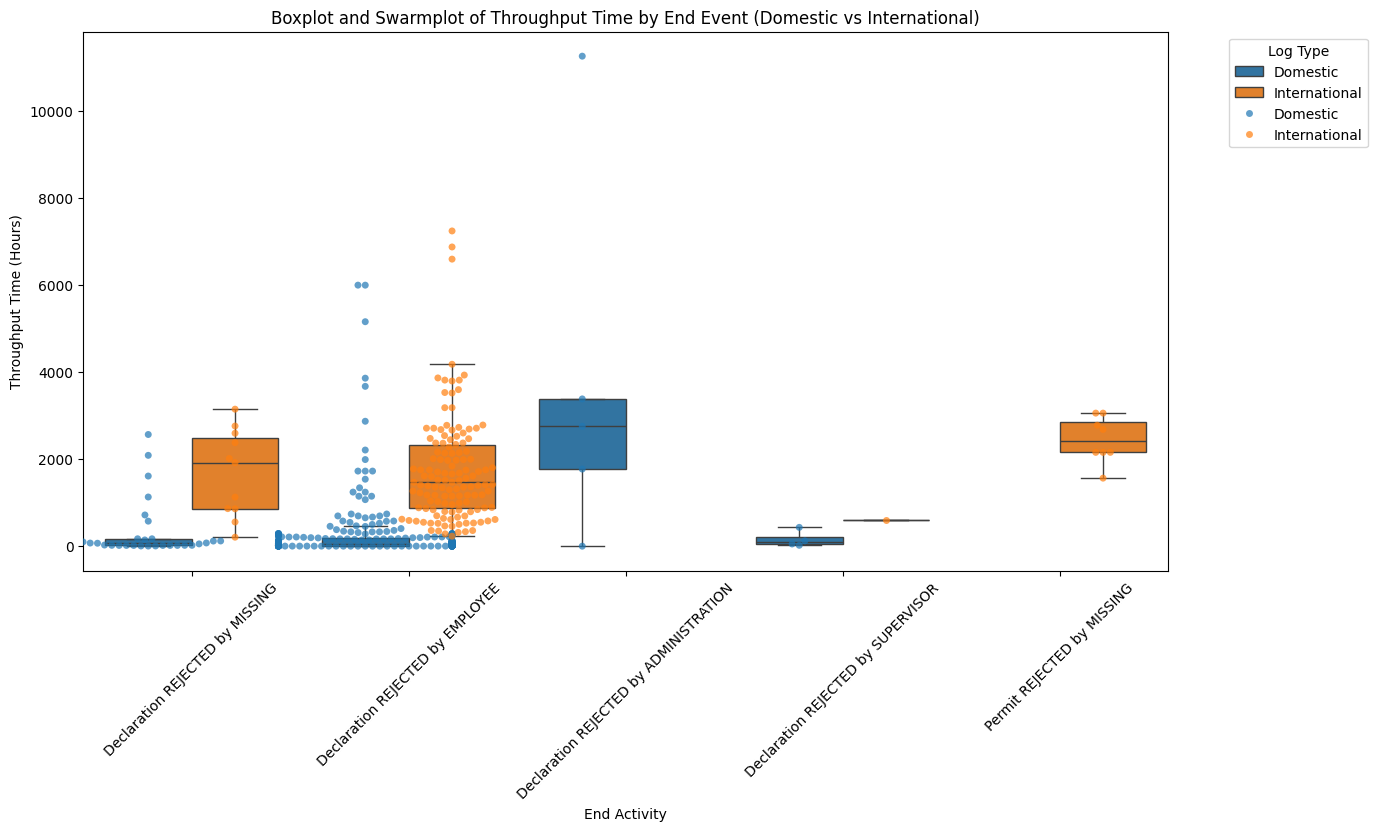

In [158]:
import pm4py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate case durations and prepare data
def prepare_data(log, log_type):
    end_activities = []
    case_durations = []
    for trace in log:
        # Get the end activity (last event's activity name)
        end_activity = trace[-1]['concept:name']
        end_activities.append(end_activity)

        # Calculate the duration as the time difference between the first and last event in the trace
        duration = ((trace[-1]['time:timestamp'] - trace[0]['time:timestamp']).total_seconds()/60/60)
        case_durations.append(duration)
    
    # Create a DataFrame to map end activities to their respective durations and add log type
    data = {'End Activity': end_activities, 'Duration': case_durations, 'Log Type': log_type}
    return pd.DataFrame(data)

# Prepare data for both logs
df_domestic = prepare_data(filtered_log_rejected_domestic, 'Domestic')
df_international = prepare_data(filtered_log_rejected_international, 'International')

# Combine both dataframes
df_combined = pd.concat([df_domestic, df_international])

# Plot the boxplot and swarmplot using seaborn
plt.figure(figsize=(14, 7))
sns.boxplot(x='End Activity', y='Duration', hue='Log Type', data=df_combined, showfliers=False)
sns.swarmplot(x='End Activity', y='Duration', hue='Log Type', data=df_combined, dodge=True, marker='o', alpha=0.7)

# Customize the plot
plt.title('Boxplot and Swarmplot of Throughput Time by End Event (Domestic vs International)')
plt.xlabel('End Activity')
plt.ylabel('Throughput Time (Hours)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='Log Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [159]:
print(len(log_domestic))
print(len(log_international))
print(len(filtered_log_rejected_domestic))
print(len(filtered_log_rejected_international))

56437
72151
323
150


c:\Users\flemm\AppData\Local\pypoetry\Cache\virtualenvs\code-ha-process-mining-2oP8IPjh-py3.11\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 68.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


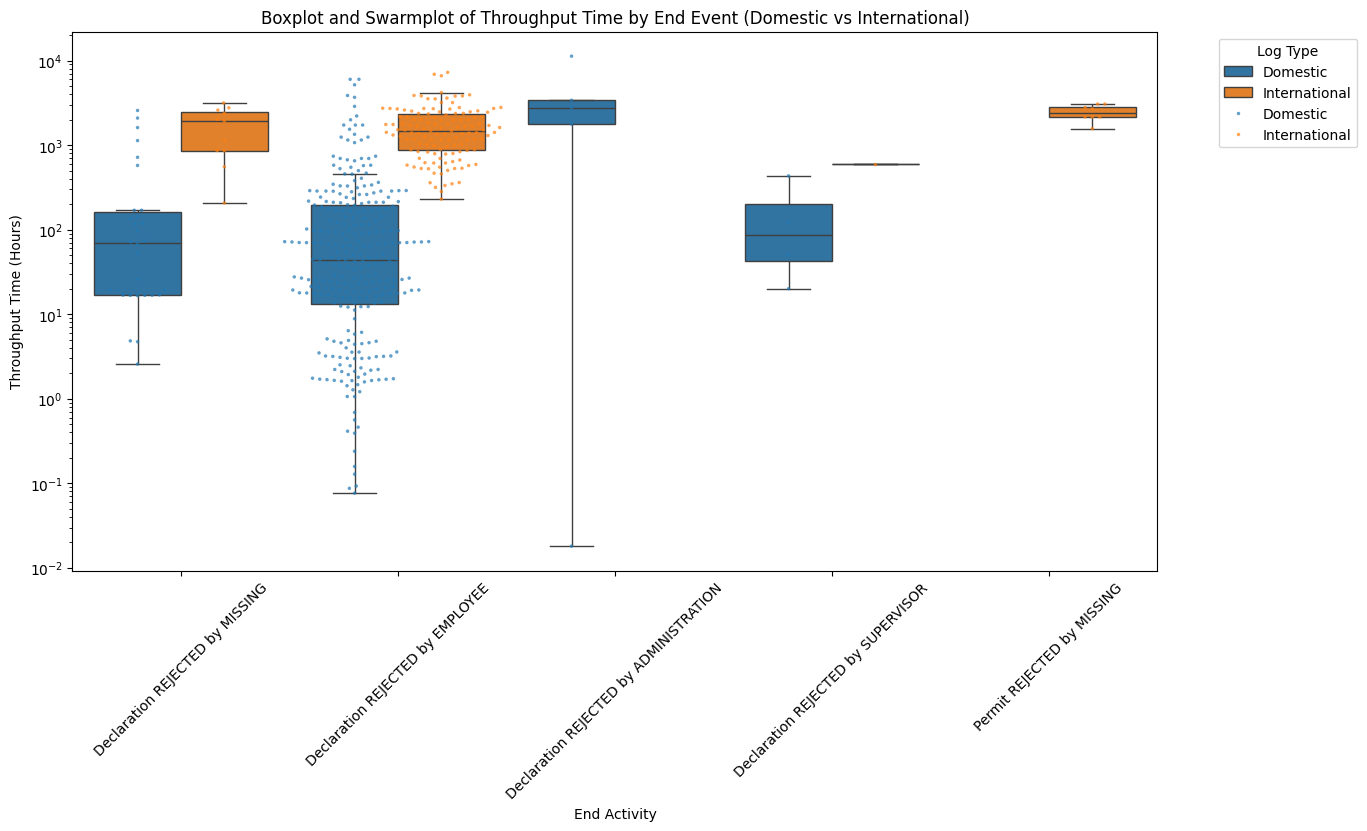

In [160]:
import pm4py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate case durations and prepare data
def prepare_data(log, log_type):
    end_activities = []
    case_durations = []
    for trace in log:
        # Get the end activity (last event's activity name)
        end_activity = trace[-1]['concept:name']
        end_activities.append(end_activity)

        # Calculate the duration as the time difference between the first and last event in the trace
        duration = ((trace[-1]['time:timestamp'] - trace[0]['time:timestamp']).total_seconds()/60/60)
        case_durations.append(duration)
    
    # Create a DataFrame to map end activities to their respective durations and add log type
    data = {'End Activity': end_activities, 'Duration': case_durations, 'Log Type': log_type}
    return pd.DataFrame(data)

# Prepare data for both logs
df_domestic = prepare_data(filtered_log_rejected_domestic, 'Domestic')
df_international = prepare_data(filtered_log_rejected_international, 'International')

# Combine both dataframes
df_combined = pd.concat([df_domestic, df_international])

# Plot the boxplot and swarmplot using seaborn
plt.figure(figsize=(14, 7))
sns.boxplot(x='End Activity', y='Duration', hue='Log Type', data=df_combined, showfliers=False)
sns.swarmplot(x='End Activity', y='Duration', hue='Log Type', data=df_combined, dodge=True, marker='.', alpha=0.7)

# Scale the y-axis logarithmically
plt.yscale('log')

# Customize the plot
plt.title('Boxplot and Swarmplot of Throughput Time by End Event (Domestic vs International)')
plt.xlabel('End Activity')
plt.ylabel('Throughput Time (Hours)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='Log Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [161]:
df_international

,End Activity,Duration,Log Type
0,Permit REJECTED by MISSING,1563.707778,International
1,Permit REJECTED by MISSING,3058.207778,International
2,Permit REJECTED by MISSING,3058.207778,International
3,Declaration REJECTED by MISSING,2761.460000,International
4,Declaration REJECTED by MISSING,1918.432778,International
...,...,...,...
145,Declaration REJECTED by EMPLOYEE,840.960833,International
146,Declaration REJECTED by EMPLOYEE,837.236944,International
147,Declaration REJECTED by EMPLOYEE,528.642500,International
148,Declaration REJECTED by EMPLOYEE,528.650278,International


In [162]:
df_domestic

,End Activity,Duration,Log Type
0,Declaration REJECTED by MISSING,73.763611,Domestic
1,Declaration REJECTED by MISSING,71.533611,Domestic
2,Declaration REJECTED by MISSING,25.951111,Domestic
3,Declaration REJECTED by EMPLOYEE,12.275278,Domestic
4,Declaration REJECTED by EMPLOYEE,13.555278,Domestic
...,...,...,...
318,Declaration REJECTED by SUPERVISOR,20.017222,Domestic
319,Declaration REJECTED by SUPERVISOR,122.156389,Domestic
320,Declaration REJECTED by EMPLOYEE,1.468889,Domestic
321,Declaration REJECTED by SUPERVISOR,432.211111,Domestic


In [163]:
df_combined.columns

Index(['End Activity', 'Duration', 'Log Type'], dtype='object')

In [164]:
import pandas as pd

# Assuming df_combined is your DataFrame
pivot_table = df_combined.pivot_table(
    index='End Activity',  # Rows
    columns='Log Type',    # Columns
    values='Duration',     # Values to aggregate
    aggfunc=['mean', 'std'] # Aggregation functions (mean, std, count)
)

# Display the pivot table
print(pivot_table)


                                               mean                \
Log Type                                   Domestic International   
End Activity                                                        
Declaration REJECTED by ADMINISTRATION  3834.963667           NaN   
Declaration REJECTED by EMPLOYEE         261.084238   1734.760026   
Declaration REJECTED by MISSING          336.727583   1675.302803   
Declaration REJECTED by SUPERVISOR       156.206667    599.160833   
Permit REJECTED by MISSING                      NaN   2451.410104   

                                                std                
Log Type                                   Domestic International  
End Activity                                                       
Declaration REJECTED by ADMINISTRATION  4344.557690           NaN  
Declaration REJECTED by EMPLOYEE         738.262312   1227.678744  
Declaration REJECTED by MISSING          654.373752    995.321147  
Declaration REJECTED by SUPERVISOR     